In [1]:
# Import packages 
import os, glob, sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import cv2

from tqdm.auto import tqdm
from ipywidgets import FloatProgress
from scipy import ndimage
from PIL import Image
from importlib import reload

# append path
sys.path.append('../')

# custom
from utils.BuildWNet import WNet
from utils.GetLowestGPU import GetLowestGPU
from utils.WNetTileGenerator import TileGenerator
from utils.Metrics import iou
from utils.AreaCalc import area_calc
import utils.SegmentImage as SegmentImage
import utils.MeasureLeaves as MeasureLeaves

device = torch.device(GetLowestGPU(verbose=2))

---------------------------
 GPU | Memory-usage    
---------------------------
  0  | 00560MiB / 40537MiB
  1  | 01316MiB / 40537MiB
  2  | 00003MiB / 40537MiB
  3  | 00003MiB / 40537MiB
  4  | 00003MiB / 40537MiB
  5  | 00003MiB / 40537MiB
  6  | 00003MiB / 40537MiB
  7  | 00003MiB / 40537MiB
---------------------------
 Device set to cuda:2
---------------------------


# Import Best Model Weights

In [2]:
# Load model
# instantiate model

wnet = WNet(k = 4)
opt = torch.optim.AdamW(wnet.parameters(), lr=1e-3)
loss_function = torch.nn.CrossEntropyLoss()


In [11]:
# find iteration with lowest loss
log_path = '../logs/'
log = pd.read_csv(log_path + 'log.csv')
best_loss = log.iloc[log["val_n_cut"].idxmin()]["iter_num"].astype(int)

In [12]:
# load model weights
checkpoint = torch.load(f"../checkpoints/checkpoint_{best_loss}.pt", map_location=device)

#extract weights from checkpoint
weights = checkpoint["model"]
# trained model has been loaded
wnet.load_state_dict(weights)
wnet.eval()#inference mode (no dropout, batch norm uses running mean, etc.)
wnet.to(device)

WNet(
  (U_encoder): UNet(
    (hidden_activation): LeakyReLU(negative_slope=0.01)
    (enc_layers): ModuleList(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Dropout2d(p=0.1, inplace=False)
      (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): LeakyReLU(negative_slope=0.01)
      (7): Dropout2d(p=0.1, inplace=False)
      (8): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): LeakyReLU(negative_slope=0.01)
      (11): Dropout2d(p=0.1, inplace=False)
      (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (13): Conv2d(32, 64, kernel_size=(

# Load Images

In [13]:
# load in images
# options
image_path = "../data/test/images/"
mask_path = "../data/test/masks/"
save_path = "../data/test/predictions/"

# load image data
image_names = glob.glob(mask_path + "*.png")
image_names = [os.path.basename(x) for x in image_names]

# Create Predicted Segmentation Masks for Images

Processing 1.tt8t x fc6-1.B.WBP-2022.W.png


  0%|          | 0/9265 [00:00<?, ?it/s]

Jaccard Distance (IoU) for wing: 0.7548

Jaccard Distance (IoU) for envelope: 0.4303

Jaccard Distance (IoU) for seeds: 0.5651

Processing 10.tt8t x fc5-2.B.WBP-2022.W.png


  0%|          | 0/9265 [00:00<?, ?it/s]

Jaccard Distance (IoU) for wing: 0.6581

Jaccard Distance (IoU) for envelope: 0.4069

Jaccard Distance (IoU) for seeds: 0.4314

Processing 9_5.tt8t x fc5-1.B.WBP-2022.W_rep2.png


  0%|          | 0/9265 [00:00<?, ?it/s]

Jaccard Distance (IoU) for wing: 0.7944

Jaccard Distance (IoU) for envelope: 0.4299

Jaccard Distance (IoU) for seeds: 0.0699

Average Jaccard Distance (IoU) for wing: 0.7357

Average Jaccard Distance (IoU) for envelope: 0.4224

Average Jaccard Distance (IoU) for seeds: 0.3555



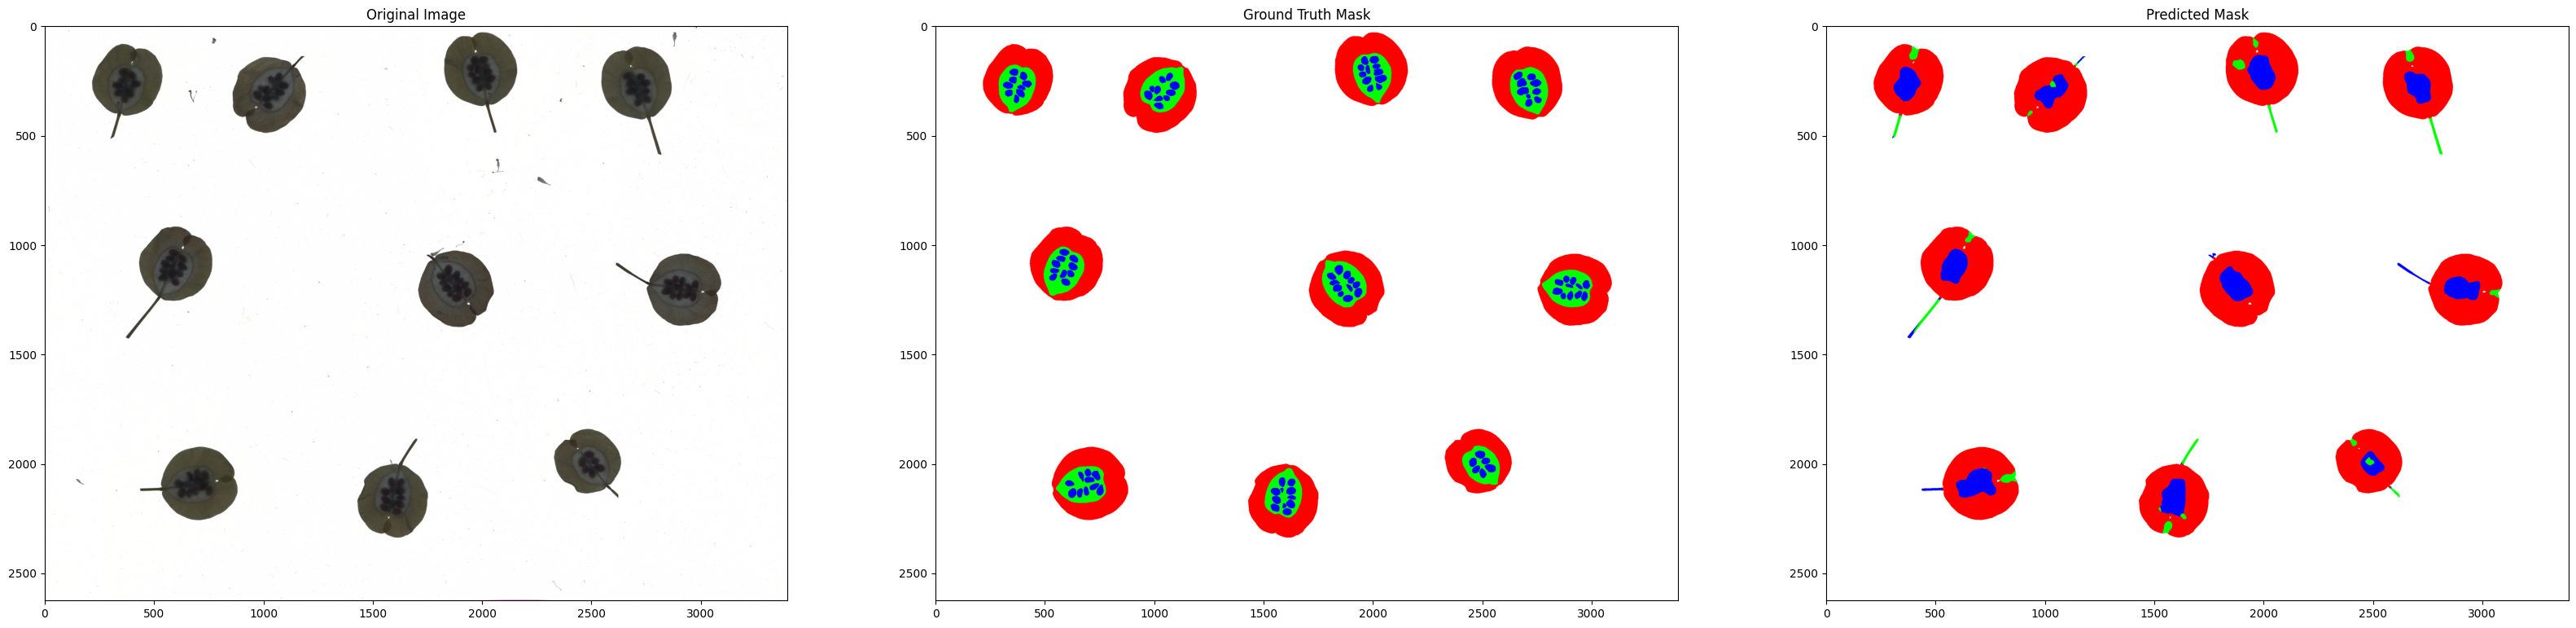

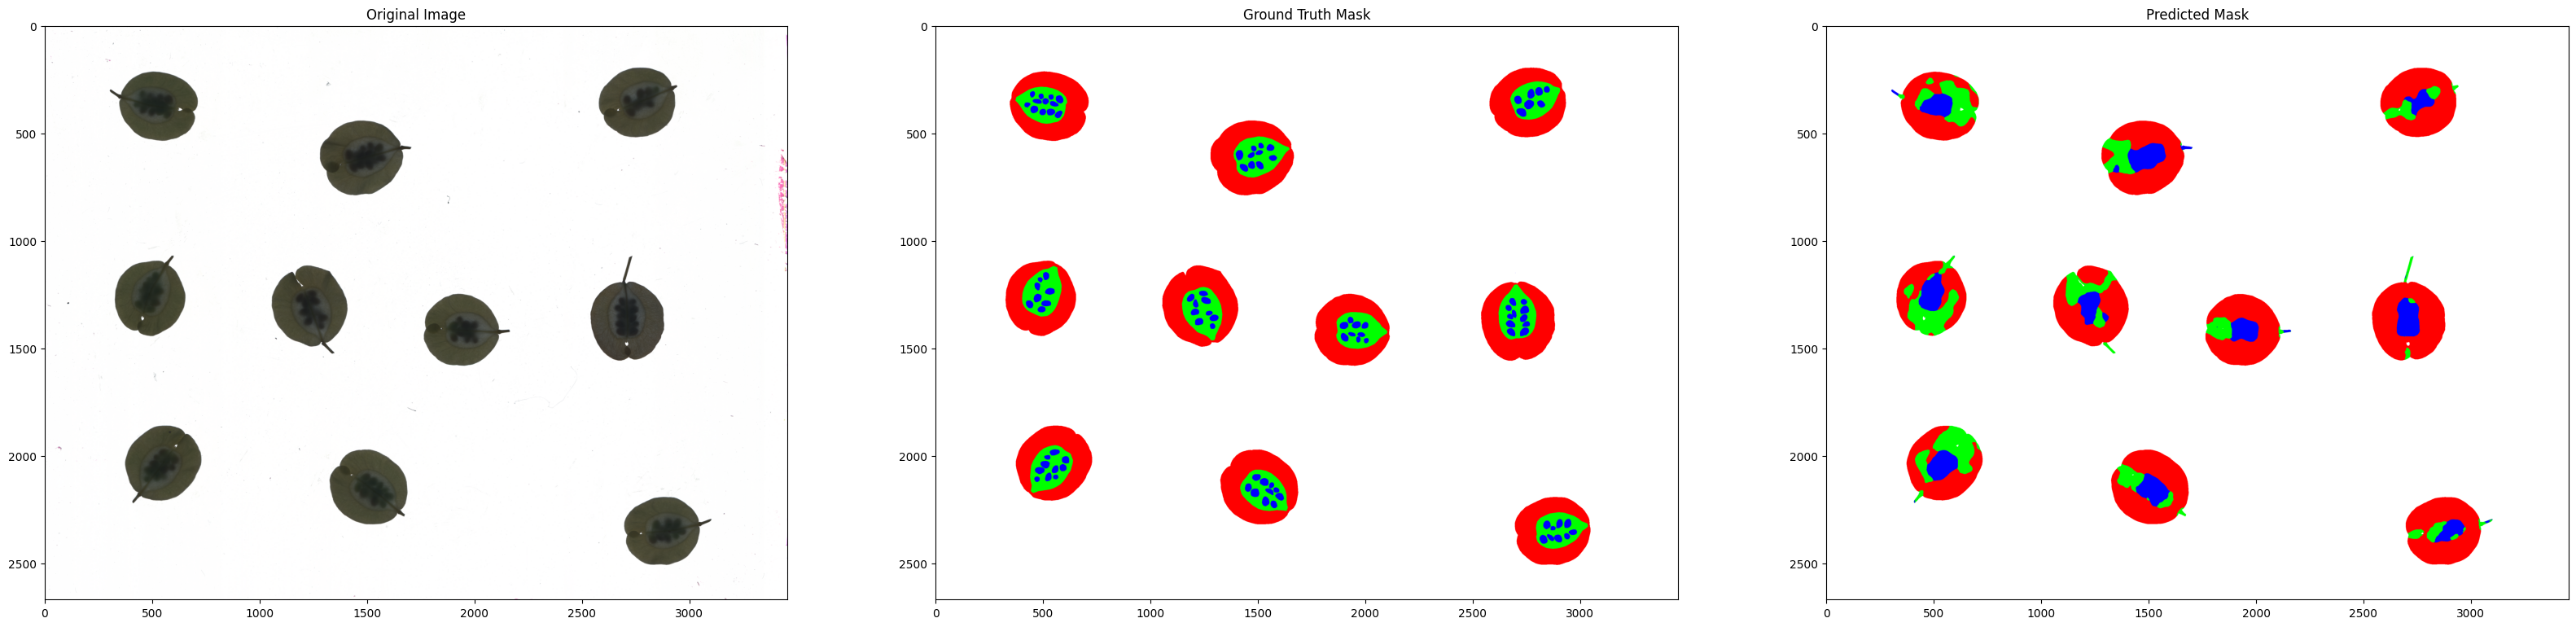

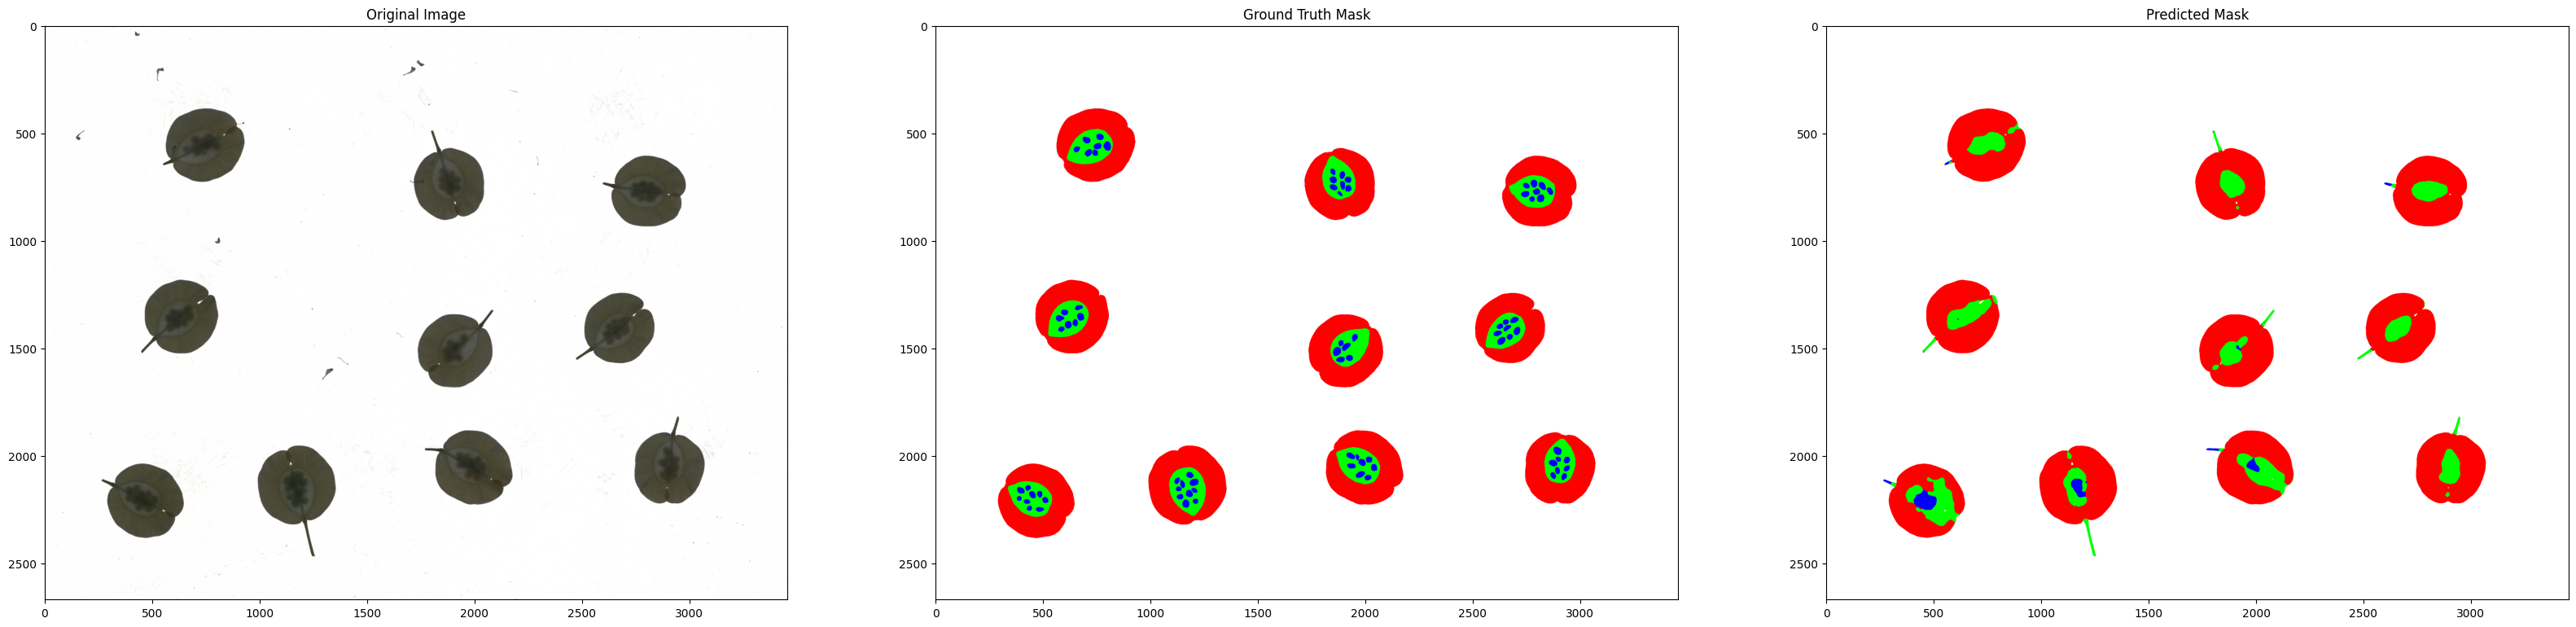

In [14]:
reload(SegmentImage)
SegmentImage.segment_image(model = wnet,
                           image_names = image_names,
                           image_path = image_path,
                           mask_path = mask_path,
                           save_path = save_path,
                           plot = True,
                           verbose = 2,
                           device = device)